[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

This follows what we did previously.

In [13]:
# from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI as ChatOpenAI
from langchain_core.tools import tool
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b
@tool
# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b
@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def greeting(name:str) -> str:
    """Greet a person"""
    return ("Howya doing!!", name)

def general_llm(text:str) ->str:
    """general purpose llm"""
    llm = ChatOpenAI(model="gemini-2.0-flash-lite")
    response= llm.invoke(text)
    print("resposne:",response)
    return response

tools = [add, multiply, divide,greeting, general_llm]
llm = ChatOpenAI(model="gemini-2.0-flash-lite")
llm_with_tools = llm.bind_tools(tools)

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant Which selects the best course of action and execute it through" \
"various tools")

# Node
def assistant(state: MessagesState):
   print("here",state)
   x={"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
   print("state modifed",x)
   return x

def greet_assistant(state:MessagesState):
   print('greet',state)
   return {"messages":[llm_greet.invoke([sys_msg] + state["messages"])]}

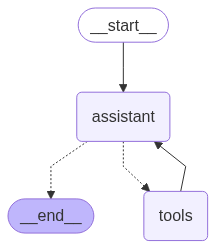

In [15]:
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# builder.add_node("greetings",greet_assistant)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
# builder.add_edge("assistant","greetings")

builder.add_edge( "tools","assistant")
# builder.add_edge("greetings",END)
react_graph = builder.compile()

# Show
try:
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
except:pass

## Memory

Let's run our agent, as before.

In [16]:
messages = [HumanMessage(content="what a transformer architecture")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

here {'messages': [HumanMessage(content='what a transformer architecture', additional_kwargs={}, response_metadata={}, id='730106c9-1596-4aaa-8fa1-994993641d1e')]}
state modifed {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'general_llm', 'arguments': '{"text": "what a transformer architecture"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--ff17cc36-f06d-42cd-95c3-156f296388b6-0', tool_calls=[{'name': 'general_llm', 'args': {'text': 'what a transformer architecture'}, 'id': '4152152c-93b3-4527-aa82-cdaaf471bb63', 'type': 'tool_call'}], usage_metadata={'input_tokens': 129, 'output_tokens': 9, 'total_tokens': 138, 'input_token_details': {'cache_read': 0}})]}
resposne: content='A transformer architecture is a deep learning model that has revolutionized the field of natural language processing (NLP) and is also finding app

Now, let's multiply by 2!

In [41]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

here {'messages': [HumanMessage(content='Multiply that by 2.', additional_kwargs={}, response_metadata={}, id='919daddb-93b7-4e61-9d21-99f59eeef64f')]}
messages
state modifed {'messages': [AIMessage(content='I need two numbers to multiply. Could you please provide them?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--b8b1b5a2-2a00-4ffe-92ab-68b97dca18b0-0', usage_metadata={'input_tokens': 119, 'output_tokens': 14, 'total_tokens': 133, 'input_token_details': {'cache_read': 0}})]}
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

I need two numbers to multiply. Could you please provide them?


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

In [17]:
from langchain_core.globals import set_llm_cache
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

In [18]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory, cache=True)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [19]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

here {'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='74547d33-921c-46ec-9802-5db5ec4df1b0')]}
state modifed {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 4.0, "a": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--e86ca31b-01ac-4136-8ece-1005b294ca49-0', tool_calls=[{'name': 'add', 'args': {'b': 4.0, 'a': 3.0}, 'id': 'b984ce51-fa8c-4ad5-ad0f-c5f8a344efb7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 5, 'total_tokens': 137, 'input_token_details': {'cache_read': 0}})]}
here {'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='74547d33-921c-46ec-9802-5db5ec4df1b0'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 4.0, "a"

If we pass the same `thread_id`, then we can proceed from from the previously logged state checkpoint! 

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [22]:
messages = [HumanMessage(content="vance age is the answer of previous executions, look into the data, what is his age?use history of this run")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

here {'messages': [HumanMessage(content='Add 3 and 4.', additional_kwargs={}, response_metadata={}, id='74547d33-921c-46ec-9802-5db5ec4df1b0'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"b": 4.0, "a": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-lite', 'safety_ratings': []}, id='run--e86ca31b-01ac-4136-8ece-1005b294ca49-0', tool_calls=[{'name': 'add', 'args': {'b': 4.0, 'a': 3.0}, 'id': 'b984ce51-fa8c-4ad5-ad0f-c5f8a344efb7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 5, 'total_tokens': 137, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='7', name='add', id='eaf6016b-d63d-4b22-b402-e65737fe7679', tool_call_id='b984ce51-fa8c-4ad5-ad0f-c5f8a344efb7'), AIMessage(content='The result is 7.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, '

## LangGraph Studio


**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `module-1/studio/` directory in this module:

```
langgraph dev
```